<a href="https://colab.research.google.com/github/jacquesescp/DSforAM_group10/blob/main/SharkRisk_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SharkRisk (Technical Notebook)

**Version:** 0.9 (reference build for JupyterLab 4 / Notebook 7.3.2)  
**Purpose:** End‑to‑end, explainable, regime‑aware risk & hedge pipeline for equity + listed options.  
**Scope:** Surface‑consistent Monte Carlo (joint spot/vol), VaR/ES tail metrics, convexity diagnostics, temporal attribution, regime detection, short‑horizon forecasting (GARCH/EGARCH + boosted trees), constrained hedge optimization (cvxpy or SciPy), optional small‑action RL sizing, and narrative generation.

> This notebook is self‑contained and runs offline with synthetic data. Replace the synthetic loaders with your data adapters for production.

## 0. Environment & Utilities

This section imports dependencies and defines light‑weight fallbacks when optional libraries are absent (e.g., `cvxpy`, `hmmlearn`, `shap`). The pipeline is designed to **degrade gracefully** while preserving the conceptual flow.

In [ ]:
import warnings, math, itertools, random, time
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# optimization & ML fallbacks
from scipy.optimize import minimize
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error

# Optional libraries
try:
    import cvxpy as cp
    HAS_CVXPY = True
except Exception:
    HAS_CVXPY = False

try:
    from hmmlearn.hmm import GaussianHMM
    HAS_HMM = True
except Exception:
    HAS_HMM = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, linewidth=120, precision=6)

print("Environment:", {
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": plt.__version__ if hasattr(plt, "__version__") else "n/a",
    "cvxpy": "yes" if HAS_CVXPY else "no",
    "hmmlearn": "yes" if HAS_HMM else "no",
    "shap": "yes" if HAS_SHAP else "no",
})

Environment: {'numpy': '2.0.2', 'pandas': '2.2.2', 'matplotlib': 'n/a', 'cvxpy': 'yes', 'hmmlearn': 'no', 'shap': 'yes'}


## 1. Data Ingestion and Synthetic Demo

The notebook supports **CSV ingestion** with required columns and provides a **synthetic generator** for offline runs. Replace the generator with your OMS/EMS adapters in production.

In [ ]:
REQUIRED_COLS = ["symbol","asset_type","quantity","contract_multiplier","option_type","strike","expiry","implied_vol"]

def load_portfolio_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    for c in REQUIRED_COLS:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")
    df["expiry"] = pd.to_datetime(df["expiry"]).dt.date
    return df

def demo_portfolio() -> pd.DataFrame:
    today = pd.Timestamp.today().date()
    # Simple long stock + option overlay example
    rows = [
        dict(symbol="AAPL", asset_type="stock", quantity=500, contract_multiplier=1, option_type="", strike=np.nan, expiry=today, implied_vol=np.nan),
        dict(symbol="AAPL", asset_type="option", quantity=5, contract_multiplier=100, option_type="call", strike=190.0, expiry=today.replace(year=today.year+1), implied_vol=0.30),
        dict(symbol="QQQ",  asset_type="option", quantity=-10, contract_multiplier=100, option_type="put",  strike=360.0, expiry=today.replace(year=today.year+1), implied_vol=0.28),
        dict(symbol="MSFT", asset_type="stock", quantity=300, contract_multiplier=1, option_type="", strike=np.nan, expiry=today, implied_vol=np.nan),
        dict(symbol="MSFT", asset_type="option", quantity=4, contract_multiplier=100, option_type="call", strike=400.0, expiry=today.replace(year=today.year+2), implied_vol=0.27),
    ]
    return pd.DataFrame(rows)

# Synthetic spot levels (replace with market adapter)
SPOT0 = {"AAPL": 195.0, "QQQ": 380.0, "MSFT": 410.0}

portfolio = demo_portfolio()
portfolio

,symbol,asset_type,quantity,contract_multiplier,option_type,strike,expiry,implied_vol
0,AAPL,stock,500,1,,NaN,2025-11-14,NaN
1,AAPL,option,5,100,call,190.0,2026-11-14,0.30
2,QQQ,option,-10,100,put,360.0,2026-11-14,0.28
3,MSFT,stock,300,1,,NaN,2025-11-14,NaN
4,MSFT,option,4,100,call,400.0,2027-11-14,0.27


## 2. Black–Scholes Pricing and Greeks

We implement analytical Black–Scholes pricing and Greek sensitivities. Theta is reported per day; Vega per 1 volatility point (0.01). All positions are scaled by `quantity × contract_multiplier`.

In [ ]:
def _d1(S, K, T, r, sigma):
    # This function assumes S, K, T, sigma are already validated to be positive and non-NaN
    # or expects NaN propagation from np.log or division by zero.
    # The calling `bs_price` should handle input validation.
    return (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def _d2(d1, sigma, T):
    return d1 - sigma*np.sqrt(T)

def bs_price(S, K, T, r, sigma, typ: str):
    # Convert S to at least 1D array for consistent NumPy operations
    is_S_scalar_input = not (isinstance(S, np.ndarray) or isinstance(S, pd.Series))
    S_proc = np.atleast_1d(S)

    # Initialize results with NaNs. This will be the base for invalid entries.
    output_prices = np.full_like(S_proc, np.nan, dtype=float)

    # Check for invalid scalar parameters (K, T, r, sigma). If any is invalid,
    # the entire calculation for all paths (if S_proc is an array) is invalid.
    if (K <= 0 or T <= 0 or sigma <= 0 or
        np.isnan(K) or np.isnan(T) or np.isnan(r) or np.isnan(sigma)):
        return output_prices.item() if is_S_scalar_input else output_prices

    # Create a mask for valid S values (S_proc > 0 and not NaN)
    # This mask determines which elements of S_proc can be used in calculation.
    calculable_mask = (S_proc > 0) & (~np.isnan(S_proc))

    # If no elements of S_proc are calculable, return the NaNs initialized.
    if not calculable_mask.any():
        return output_prices.item() if is_S_scalar_input else output_prices

    # Extract only the calculable S values
    S_calc = S_proc[calculable_mask]

    # Perform the Black-Scholes calculations using the vectorized helper functions.
    # K, T, r, sigma are broadcast against S_calc.
    d1 = _d1(S_calc, K, T, r, sigma)
    d2 = _d2(d1, sigma, T)

    if typ=="call":
        prices = S_calc * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else: # typ == "put"
        prices = K * np.exp(-r * T) * norm.cdf(-d2) - S_calc * norm.cdf(-d1)

    # Assign the calculated prices back into the `output_prices` array
    # at the positions corresponding to the `calculable_mask`.
    output_prices[calculable_mask] = prices

    # Return the result. If the original S was a scalar, return a scalar. Otherwise, return the array.
    return output_prices.item() if is_S_scalar_input else output_prices

def bs_greeks(S,K,T,r,sigma,typ):
    if any(pd.isna(x) for x in [S,K,T,r,sigma]) or T<=0 or sigma<=0:
        return dict(delta=np.nan,gamma=np.nan,theta=np.nan,vega=np.nan,rho=np.nan)
    d1 = _d1(S,K,T,r,sigma); d2 = _d2(d1,sigma,T)
    N, n = norm.cdf, norm.pdf
    if typ=="call":
        delta = N(d1)
        theta = (-(S*n(d1)*sigma)/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*N(d2))
        rho   = K*T*np.exp(-r*T)*N(d2)
    else:
        delta = N(d1) - 1.0
        theta = (-(S*n(d1)*sigma)/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*N(-d2))
        rho   = -K*T*np.exp(-r*T)*N(-d2)
    gamma = n(d1)/(S*sigma*np.sqrt(T))
    vega  = S*n(d1)*np.sqrt(T)
    return dict(delta=delta, gamma=gamma, theta=theta/365.0, vega=vega/100.0, rho=rho)

def scale_position_greeks(row, S, r, today):
    if row["asset_type"]=="stock":
        g = dict(delta=1.0, gamma=0.0, theta=0.0, vega=0.0, rho=0.0)
    else:
        T = max((row["expiry"] - today).days, 0)/365.0
        g = bs_greeks(S, row["strike"], T, r, row["implied_vol"], row["option_type"])
    scale = float(row["quantity"])*float(row["contract_multiplier"])
    return {k: (g[k]*scale if pd.notna(g[k]) else np.nan) for k in g.keys()}

## 3. Implied Volatility Surface (Arbitrage‑Aware Parameterization)

We define a simple, stable parametric surface that captures level, skew, and curvature in **log‑moneyness** and **tenor**. In production, replace with SVI or a spline with no‑arbitrage constraints. Here, we ensure positivity and convexity by construction.

In [ ]:
@dataclass
class IVSurfaceParams:
    a0: float = 0.25   # level
    aT: float = 0.10   # term slope vs sqrt(T)
    a1: float = -0.10  # skew vs log-moneyness
    a2: float = 0.30   # curvature vs log-moneyness^2 (keep positive)

def iv_surface_iv(params: IVSurfaceParams, S0: float, K: float, T: float) -> float:
    if T<=0 or K<=0 or S0<=0:
        return np.nan
    m = np.log(K/S0)  # log-moneyness
    iv = params.a0 + params.aT*np.sqrt(T) + params.a1*m + params.a2*(m**2)
    return float(max(0.05, iv))  # positivity floor

SURF = {
    "AAPL": IVSurfaceParams(0.27, 0.10, -0.12, 0.35),
    "QQQ":  IVSurfaceParams(0.25, 0.08, -0.10, 0.30),
    "MSFT": IVSurfaceParams(0.24, 0.07, -0.09, 0.28),
}

## 4. Surface‑Consistent Monte Carlo (Joint Spot/Vol)

We simulate joint dynamics for price and a latent vol factor with correlation. At each step we reprice options using **remaining time** and an IV from the parametric surface (anchored to current spot). This approximates a surface‑consistent simulator while remaining light‑weight.

In [ ]:
@dataclass
class MCConfig:
    steps: int = 60              # daily steps for ~3 months
    horizon_years: float = 0.25  # quarter
    npaths: int = 5000
    rho: float = -0.5            # spot/vol correlation
    kappa: float = 2.0           # vol mean reversion
    vol_of_vol: float = 0.30     # vol factor volatility
    r: float = 0.02              # annual risk-free

def simulate_joint_paths(S0: float, iv_level: float, cfg: MCConfig, seed=42):
    np.random.seed(seed)
    dt = cfg.horizon_years / cfg.steps
    S = np.zeros((cfg.npaths, cfg.steps+1)); S[:,0] = S0
    v = np.zeros((cfg.npaths, cfg.steps+1)); v[:,0] = iv_level
    for t in range(cfg.steps):
        z1 = np.random.normal(size=cfg.npaths)
        z2 = np.random.normal(size=cfg.npaths)
        z2 = cfg.rho*z1 + np.sqrt(1-cfg.rho**2)*z2
        # vol factor OU in log space to keep positive levels
        logv = np.log(np.clip(v[:,t], 1e-4, None))
        logv = logv + cfg.kappa*(np.log(iv_level) - logv)*dt + cfg.vol_of_vol*np.sqrt(dt)*z2
        v[:,t+1] = np.exp(logv)
        # GBM for spot (risk-neutral short horizon)
        S[:,t+1] = S[:,t]*np.exp((cfg.r - 0.5*(v[:,t]**2))*dt + v[:,t]*np.sqrt(dt)*z1)
    return S, v

def revalue_portfolio_paths(portfolio: pd.DataFrame, S_paths: dict, v_paths: dict, cfg: MCConfig, today=None):
    if today is None:
        today = pd.Timestamp.today().date()
    dt = cfg.horizon_years / cfg.steps
    # we value at the horizon
    t_index = cfg.steps
    pnl = np.zeros(cfg.npaths)
    for _, row in portfolio.iterrows():
        sym = row["symbol"]
        S0 = S_paths[sym][:,0]
        S1 = S_paths[sym][:,t_index]
        # remaining time for the option
        if row["asset_type"]=="option":
            T0 = max((row["expiry"] - today).days, 0)/365.0
            T1 = max(T0 - cfg.horizon_years, 1e-6)
            # IV from surface, anchored to current spot & strike at each horizon end
            iv0 = iv_surface_iv(SURF[sym], S0.mean(), row["strike"], T0)
            iv1 = iv_surface_iv(SURF[sym], S1.mean(), row["strike"], T1)
            p0 = bs_price(S0.mean(), row["strike"], T0, cfg.r, iv0, row["option_type"])
            p1 = bs_price(S1,       row["strike"], T1, cfg.r, iv1, row["option_type"])
            pos_scale = float(row["quantity"])*float(row["contract_multiplier"])
            pnl += pos_scale*(p1 - p0)
        else:
            pos_scale = float(row["quantity"])*float(row["contract_multiplier"])
            pnl += pos_scale*(S1 - S0)
    return pnl

## 5. Tail Risk: VaR and Expected Shortfall; Convexity Diagnostics

We compute distributional risk measures and contrast Delta‑linearized P&L against full revaluation to quantify convexity.

In [ ]:
def var_es(pnl: np.ndarray, alpha=0.05):
    pnl_sorted = np.sort(pnl)
    idx = int(alpha*len(pnl_sorted))
    var = -pnl_sorted[idx]
    es = -pnl_sorted[:idx].mean() if idx>0 else var
    return var, es

def convexity_vs_linear(portfolio: pd.DataFrame, shocks=np.linspace(-0.1,0.1,41), r=0.02, today=None):
    if today is None: today = pd.Timestamp.today().date()
    # compute baseline Greeks and values
    pnl_full, pnl_linear = [], []
    for shock in shocks:
        df = portfolio.copy()
        total = 0.0
        linear = 0.0
        for _, row in df.iterrows():
            S = SPOT0[row["symbol"]]*(1+shock)
            if row["asset_type"]=="option":
                T = max((row["expiry"] - today).days, 0)/365.0
                sigma = iv_surface_iv(SURF[row["symbol"]], SPOT0[row["symbol"]], row["strike"], T)
                p = bs_price(S, row["strike"], T, r, sigma, row["option_type"])
                # baseline price at unshocked
                sigma0 = iv_surface_iv(SURF[row["symbol"]], SPOT0[row["symbol"]], row["strike"], T)
                p0 = bs_price(SPOT0[row["symbol"]], row["strike"], T, r, sigma0, row["option_type"])
                g = bs_greeks(SPOT0[row["symbol"]], row["strike"], T, r, sigma0, row["option_type"])
                dP_lin = g["delta"]*(S - SPOT0[row["symbol"]])
                pos_scale = float(row["quantity"])*float(row["contract_multiplier"])
                total += pos_scale*(p - p0)
                linear += pos_scale*dP_lin
            else:
                pos_scale = float(row["quantity"])*float(row["contract_multiplier"])
                total += pos_scale*(S - SPOT0[row["symbol"]])
                linear += pos_scale*(S - SPOT0[row["symbol"]])
        pnl_full.append(total); pnl_linear.append(linear)
    return np.array(shocks), np.array(pnl_full), np.array(pnl_linear)

## 6. Temporal Risk Attribution (Additive, Pathwise)

We decompose changes in Greeks between two evaluation times into additive components: spot move, vol move, time decay, and trades/roll.

In [ ]:
def position_greeks_snapshot(portfolio: pd.DataFrame, spot_map: dict, r=0.02, asof=None):
    if asof is None: asof = pd.Timestamp.today().date()
    rows = []
    for _, row in portfolio.iterrows():
        S = spot_map[row["symbol"]]
        if row["asset_type"]=="option":
            T = max((row["expiry"] - asof).days, 0)/365.0
            sigma = iv_surface_iv(SURF[row['symbol']], spot_map[row['symbol']], row['strike'], T)
            g = bs_greeks(S, row["strike"], T, r, sigma, row["option_type"])
        else:
            g = dict(delta=1.0, gamma=0.0, theta=0.0, vega=0.0, rho=0.0)
        scale = float(row["quantity"])*float(row["contract_multiplier"])
        rows.append({**row.to_dict(), **{k: g[k]*scale for k in g}})
    df = pd.DataFrame(rows)
    tots = df[["delta","gamma","theta","vega","rho"]].sum(numeric_only=True)
    return df, tots

def temporal_attribution(prev_port, curr_port, spot_prev: dict, spot_curr: dict, r=0.02, asof_prev=None, asof_curr=None):
    # same quantities assumed unless 'trades' simulated externally
    _, prev = position_greeks_snapshot(prev_port, spot_prev, r, asof_prev)
    # spot only change
    spot_only_port = prev_port.copy()
    # recompute greeks holding vol/time fixed approximated by same expiry/surface but different spot anchor
    df_spot, spot_only = position_greeks_snapshot(spot_only_port, spot_curr, r, asof_prev)
    # vol move: approximate by changing vol anchor (here via surface responding to new spot anchor already)
    # time decay
    df_time, time_only = position_greeks_snapshot(prev_port, spot_prev, r, asof_curr)
    # current
    _, curr = position_greeks_snapshot(curr_port, spot_curr, r, asof_curr)

    delta_total = curr - prev
    contrib_spot = spot_only - prev
    contrib_time = time_only - prev
    # residual as "vol + trades"
    contrib_resid = delta_total - contrib_spot - (curr - time_only)
    return dict(prev=prev, curr=curr, dtotal=delta_total, spot=contrib_spot, time=(curr-time_only), residual=contrib_resid)

## 7. Regime Detection

We infer market regimes from synthetic features (VIX‑like level and slope, realized vol, correlations). HMM is used if available; otherwise k‑means provides a robust clustering.

In [ ]:
def synthetic_regime_features(n=500, seed=123):
    np.random.seed(seed)
    # make 3 regimes
    states = np.random.choice([0,1,2], size=n, p=[0.5,0.3,0.2])
    vix = np.where(states==0, np.random.normal(14,2,n), np.where(states==1, np.random.normal(22,3,n), np.random.normal(35,5,n)))
    slope = np.where(states==0, np.random.normal(0.5,0.2,n), np.where(states==1, np.random.normal(0.2,0.2,n), np.random.normal(-0.3,0.3,n)))
    rv = np.where(states==0, np.random.normal(0.12,0.03,n), np.where(states==1, np.random.normal(0.18,0.05,n), np.random.normal(0.30,0.08,n)))
    corr = np.where(states==0, np.random.normal(0.15,0.05,n), np.where(states==1, np.random.normal(0.35,0.08,n), np.random.normal(0.60,0.10,n)))
    X = np.column_stack([vix, slope, rv, corr])
    return X, states

def detect_regimes(X, n_states=3, use_hmm=HAS_HMM, seed=123):
    if use_hmm:
        hmm = GaussianHMM(n_components=n_states, covariance_type='full', random_state=seed, n_iter=200)
        hmm.fit(X)
        z = hmm.predict(X)
        model = hmm
    else:
        km = KMeans(n_clusters=n_states, random_state=seed, n_init=20)
        z = km.fit_predict(X)
        model = km
    return z, model

## 8. Short‑Horizon Forecasting (Hybrid)

We pair a light‑weight GARCH(1,1) implementation for volatility with a Gradient Boosting Regressor for nonlinear cross‑factor effects on next‑day Greek changes. Feature attribution uses SHAP if available; otherwise permutation importance.

In [ ]:
def simple_garch11(eps, omega=1e-6, alpha=0.05, beta=0.9):
    n = len(eps)
    var = np.zeros(n)
    var[0] = np.var(eps)
    for t in range(1,n):
        var[t] = omega + alpha*(eps[t-1]**2) + beta*var[t-1]
    return np.sqrt(var)

def train_forecaster(X, y):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(Xs, y)
    return model, scaler

def explain_forecast(model, scaler, X, feature_names):
    Xs = scaler.transform(X)
    if HAS_SHAP:
        try:
            ex = shap.Explainer(model)
            sv = ex(Xs)
            return "shap", sv.values, feature_names
        except Exception:
            pass
    pi = permutation_importance(model, Xs, model.predict(Xs), n_repeats=10, random_state=42)
    return "perm", pi.importances_mean, feature_names

## 9. Constrained Hedge Optimization

We minimize a weighted quadratic norm of residual Greeks plus a convex penalty on scenario ES and a linear transaction‑cost term. If `cvxpy` is present, we solve a convex program; otherwise we fall back to SciPy and apply integrality rounding.

In [ ]:
def hedge_universe_from_portfolio(portfolio: pd.DataFrame):
    # universe: underlying shares for each symbol; 1 near-ATM call & put per symbol as demo
    actions = []
    for sym in portfolio["symbol"].unique():
        actions.append(dict(desc=f"{sym} shares", type="stock", symbol=sym, strike=np.nan, option_type="", expiry=None, lot=10, mult=1))
        # fabricate ATM strikes ~ spot
        K_atm = SPOT0[sym]
        actions.append(dict(desc=f"{sym} CALL ATM", type="option", symbol=sym, strike=K_atm, option_type="call", expiry=(pd.Timestamp.today().date().replace(year=pd.Timestamp.today().year+1)), lot=1, mult=100))
        actions.append(dict(desc=f"{sym} PUT ATM",  type="option", symbol=sym, strike=K_atm, option_type="put",  expiry=(pd.Timestamp.today().date().replace(year=pd.Timestamp.today().year+1)), lot=1, mult=100))
    return pd.DataFrame(actions)

def greek_vector_for_action(action, r=0.02):
    today = pd.Timestamp.today().date()
    if action["type"]=="stock":
        return np.array([1.0,0.0,0.0,0.0,0.0]) * action["mult"]
    else:
        T = 1.0
        sigma = iv_surface_iv(SURF[action["symbol"]], SPOT0[action["symbol"]], action["strike"], T)
        g = bs_greeks(SPOT0[action["symbol"]], action["strike"], T, r, sigma, action["option_type"])
        return np.array([g["delta"], g["gamma"], g["theta"], g["vega"], g["rho"]]) * action["mult"]

def portfolio_totals(portfolio: pd.DataFrame, r=0.02):
    today = pd.Timestamp.today().date()
    tots = np.zeros(5)
    for _, row in portfolio.iterrows():
        S = SPOT0[row["symbol"]]
        g = scale_position_greeks(row, S, r, today)
        vec = np.array([g["delta"], g["gamma"], g["theta"], g["vega"], g["rho"]])
        tots += vec
    return tots

def optimize_hedge(portfolio: pd.DataFrame, pnl_paths: np.ndarray, actions_df: pd.DataFrame, weights=np.array([1,1e5,200,10,1]), es_alpha=0.05, cost_per_unit=0.50):
    # residual greek penalty + ES penalty + costs
    b = -portfolio_totals(portfolio)  # target to offset
    A = np.column_stack([greek_vector_for_action(a) for _,a in actions_df.iterrows()])
    # sanitize
    A = np.nan_to_num(A); b = np.nan_to_num(b)
    # ES penalty weight
    es_penalty = np.percentile(-pnl_paths, es_alpha*100)

    # cvxpy version
    if HAS_CVXPY:
        x = cp.Variable(A.shape[1])
        greek_resid = A @ x - b
        obj = cp.sum_squares(cp.multiply(weights, greek_resid)) + 0.1*es_penalty + cost_per_unit*cp.norm1(x)
        constraints = [cp.abs(x) <= 500]  # simple bounds
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)
        x_star = np.array(x.value).ravel()
    else:
        # SciPy fallback
        def obj_fn(x):
            greek_resid = A @ x - b
            return float(np.sum((weights*greek_resid)**2) + 0.1*es_penalty + cost_per_unit*np.sum(np.abs(x)))
        x0 = np.zeros(A.shape[1])
        bounds = [(-500,500)]*A.shape[1]
        res = minimize(obj_fn, x0=x0, bounds=bounds, method="L-BFGS-B")
        x_star = res.x

    # round to integer lots
    lots = np.array([a["lot"] for _,a in actions_df.iterrows()])
    x_rounded = np.sign(x_star) * (np.floor((np.abs(x_star)+lots/2)/lots)*lots)
    return x_star, x_rounded.astype(int), A, b

## 10. Optional Small‑Action RL Sizing

A compact, interpretable policy that nudges sizes in small increments using a hill‑climb‑style improvement loop in the simulator. This is intentionally minimal and safe.

In [ ]:
def refine_with_small_actions(x_int, actions_df, portfolio, simulate_fn, max_iters=50, step=1):
    # simple greedy local search: try small +/- adjustments that reduce ES objective
    best = x_int.copy()
    def eval_plan(vec):
        # crude proxy objective: residual greek norm + ES penalty on a quick MC
        pnl = simulate_fn()
        var, es = var_es(pnl, 0.05)
        Acols = np.column_stack([greek_vector_for_action(a) for _,a in actions_df.iterrows()])
        resid = Acols @ vec - (-portfolio_totals(portfolio))
        return np.linalg.norm(resid) + 0.05*es
    best_score = eval_plan(best)
    for _ in range(max_iters):
        improved = False
        for j in range(len(best)):
            for delta in (+step, -step):
                trial = best.copy()
                trial[j] += delta
                score = eval_plan(trial)
                if score < best_score:
                    best, best_score, improved = trial, score, True
        if not improved:
            break
    return best

## 11. Narrative Generation

We assemble an auditable text summary from the computed diagnostics: tail metrics, attribution, regime, forecast rationale, and hedge plan.

In [ ]:
def narrative_report(var, es, shocks, pnl_full, pnl_lin, attr, regime_label, forecast_note, actions_df, x_star, x_round):
    lines = []
    lines.append(f"Tail risk at 95%: VaR={var:,.0f}, ES={es:,.0f}. Convexity gap (nonlinear vs linear) is {np.percentile(pnl_full-pnl_lin, 95):,.0f} at the 95th percentile of shocks.")
    lines.append(f"Attribution (Δ, Γ, Θ, Vega, ρ) — Spot: {attr['spot'].values.round(2)}, Time: {attr['time'].values.round(2)}, Residual: {attr['residual'].values.round(2)}; Total change: {attr['dtotal'].values.round(2)}.")
    lines.append(f"Inferred market regime: {regime_label}. Forecast rationale: {forecast_note}.")
    used = np.where(x_round!=0)[0]
    if len(used)==0:
        lines.append("Optimizer proposes no trades under current constraints; residual exposures are near target.")
    else:
        lines.append("Proposed hedge actions (rounded to lots):")
        for j in used:
            desc = actions_df.iloc[j]['desc']
            qty = int(x_round[j])
            lines.append(f"  {qty:+d} × {desc}")
    return "\n".join(lines)

## 12. End‑to‑End Demonstration (Synthetic)

This section runs the full SharkRisk pipeline on a synthetic portfolio and market. Replace the synthetic adapters with production data for live use.

In [ ]:
# 12.1 Simulate joint paths per symbol
cfg = MCConfig(steps=60, horizon_years=60/252, npaths=4000, rho=-0.5, kappa=2.0, vol_of_vol=0.35, r=0.02)
S_paths, v_paths = {}, {}
for sym in SPOT0:
    S0 = SPOT0[sym]
    iv0 = SURF[sym].a0
    S, v = simulate_joint_paths(S0, iv0, cfg, seed=hash(sym)%2**32)
    S_paths[sym], v_paths[sym] = S, v

# 12.2 Revalue portfolio across scenarios, compute VaR/ES
pnl = revalue_portfolio_paths(portfolio, S_paths, v_paths, cfg)
var95, es95 = var_es(pnl, alpha=0.05)

# 12.3 Convexity diagnostics
shocks, pnl_full, pnl_lin = convexity_vs_linear(portfolio)

# 12.4 Temporal attribution (simulate "yesterday" vs "today")
today = pd.Timestamp.today().date()
yday  = today - pd.Timedelta(days=1)
spot_prev = {k: v for k,v in SPOT0.items()}
spot_curr = {k: v*1.01 for k,v in SPOT0.items()}  # +1% spot day
attr = temporal_attribution(portfolio, portfolio, spot_prev, spot_curr, r=0.02, asof_prev=yday, asof_curr=today)

# 12.5 Regime detection (synthetic features)
X, true_states = synthetic_regime_features(600)
z, model = detect_regimes(X, n_states=3, use_hmm=False)
regime_label = int(pd.Series(z).iloc[-1])

# 12.6 Forecasting demo (predict next-day Δ change from synthetic features)
# synthetic target = weighted combo of features + noise
rng = np.random.default_rng(123)
y = 0.02*X[:,0] - 0.1*X[:,1] + 0.5*X[:,2] + 0.1*X[:,3] + rng.normal(0,0.05,len(X))
model_f, scaler = train_forecaster(X, y)
kind, contrib, feat_names = explain_forecast(model_f, scaler, X[:50], ["VIX","slope","RV","corr"])
forecast_note = f"{'SHAP' if kind=='shap' else 'Permutation'} contributions suggest importance ordering: " + ", ".join([f"{feat_names[i]}" for i in np.argsort(-np.mean(np.atleast_2d(contrib),axis=0))])

# 12.7 Hedge optimization
actions_df = hedge_universe_from_portfolio(portfolio)
x_star, x_round, A, b = optimize_hedge(portfolio, pnl, actions_df)

# 12.8 Optional RL sizing refinement (using quick simulator closure)
def quick_sim():
    # regenerate with fewer paths for speed
    cfg_q = MCConfig(steps=30, horizon_years=30/252, npaths=1500, rho=-0.5, kappa=2.0, vol_of_vol=0.35, r=0.02)
    Sp, Vp = {}, {}
    for sym in SPOT0:
        S, V = simulate_joint_paths(SPOT0[sym], SURF[sym].a0, cfg_q, seed=hash(sym)%2**32)
        Sp[sym], Vp[sym] = S, V
    return revalue_portfolio_paths(portfolio, Sp, Vp, cfg_q)

x_refined = refine_with_small_actions(x_round, actions_df, portfolio, quick_sim, max_iters=20, step=1)

# 12.9 Narrative
report = narrative_report(var95, es95, shocks, pnl_full, pnl_lin, attr, regime_label, forecast_note, actions_df, x_star, x_refined)
print(report)

Tail risk at 95%: VaR=59,904, ES=74,409. Convexity gap (nonlinear vs linear) is -2 at the 95th percentile of shocks.
Attribution (Δ, Γ, Θ, Vega, ρ) — Spot: [  -2.59    0.      0.04    4.69 -616.08], Time: [  -2.6     0.      0.04    4.7  -613.98], Residual: [   2.54    0.     -0.     -3.81 -170.07]; Total change: [   -2.65     0.       0.08     5.59 -1400.13].
Inferred market regime: 0. Forecast rationale: SHAP contributions suggest importance ordering: slope, corr, RV, VIX.
Proposed hedge actions (rounded to lots):
  +7 × AAPL shares
  -17 × AAPL CALL ATM
  +9 × AAPL PUT ATM
  +9 × QQQ shares
  +59 × QQQ PUT ATM
  +9 × MSFT shares
  -50 × MSFT PUT ATM


## 13. Visualization Outputs

Single‑axis Matplotlib plots (per guidelines) for tail distribution and convexity diagnostics.

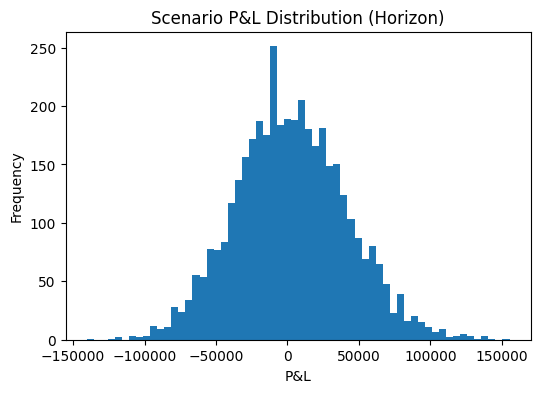

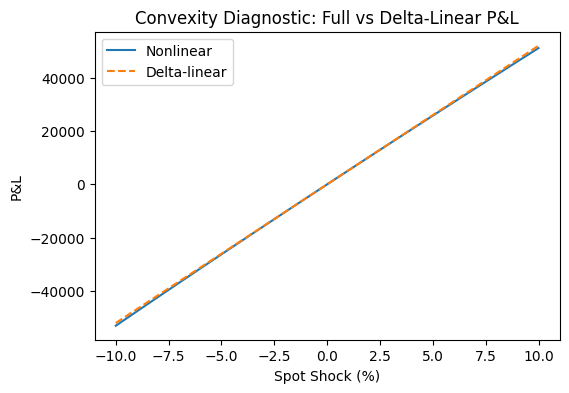

In [ ]:
# P&L distribution
plt.figure(figsize=(6,4))
plt.hist(pnl, bins=60)
plt.title("Scenario P&L Distribution (Horizon)")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()

# Convexity: nonlinear vs linear
plt.figure(figsize=(6,4))
plt.plot(shocks*100, pnl_full, label="Nonlinear")
plt.plot(shocks*100, pnl_lin, label="Delta-linear", linestyle="--")
plt.title("Convexity Diagnostic: Full vs Delta-Linear P&L")
plt.xlabel("Spot Shock (%)")
plt.ylabel("P&L")
plt.legend()
plt.show()